In [ ]:
  ! pip install EDAspy
  ! pip install pybnesian
  ! pip install pgmpy

  Preparing metadata (setup.py) ... done
  Created wheel for EDAspy: filename=EDAspy-1.1.3-py3-none-any.whl size=74157 sha256=c7f8fc61d38a03f8ac38a788b13bd0db03a35d5f5220566a2a16e7c1871df026
  Stored in directory: /root/.cache/pip/wheels/60/0b/25/b9ad093a550485c602acf9803cff6cc4382ec7a6f74269f80c
Successfully built EDAspy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nv

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import gc

from sklearn.datasets import load_iris, load_diabetes, load_digits, load_wine, \
    load_breast_cancer, fetch_california_housing, fetch_covtype
from sklearn.model_selection import train_test_split

from EDAspy.optimization import EBNA
from EDAspy.optimization import plot_bn

import networkx as nx

import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore', message='Probability values don\'t exactly sum to 1.*')
from tqdm import tqdm





import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_diabetes, load_digits, load_wine, load_breast_cancer, fetch_california_housing, fetch_covtype

def load_dataset(name, return_as_pandas=False):
    datasets = {
        'iris': load_iris,
        'diabetes': load_diabetes,
        'digits': load_digits, # es de imagenes pero como son 8x8 lo vamos a dejar como si fuera tabular
        'wine': load_wine,
        'breast_cancer': load_breast_cancer,
        'california_housing': fetch_california_housing,
        'forest_covertypes': fetch_covtype,
        # 'olivetti_faces': fetch_olivetti_faces,
        # 'lfw_people': fetch_lfw_people
    }

    if name not in datasets:
        raise ValueError(f"Dataset '{name}' no disponible.")

    data = datasets[name]()

    X, y = data.data, data.target

    # Dividir el conjunto de datos en entrenamiento, validación y prueba
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    if return_as_pandas:
        # Combinar los conjuntos en un solo DataFrame
        train_df = pd.DataFrame(X_train)
        train_df['target'] = y_train
        train_df['set'] = 'train'

        val_df = pd.DataFrame(X_val)
        val_df['target'] = y_val
        val_df['set'] = 'validation'

        test_df = pd.DataFrame(X_test)
        test_df['target'] = y_test
        test_df['set'] = 'test'

        full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
        return full_df

    return X_train, X_val, X_test, y_train, y_val, y_test




def build_model(input_dim, output_dim, hparams):
    class CustomNN(nn.Module):
        def __init__(self, input_dim, output_dim, hparams):
            super(CustomNN, self).__init__()
            self.layers = nn.ModuleList()
            self.dropout_rates = []  # Para almacenar las tasas de dropout

            layer_dims = [int(x) for x in hparams['rec_hidden_layers_config'].split('_')]
            prev_dim = input_dim

            for layer_dim in layer_dims:
                layer = nn.Linear(prev_dim, layer_dim)
                self.layers.append(layer)
                prev_dim = layer_dim

                # Verificar y almacenar la tasa de dropout si se especifica
                if 'dropout' in hparams['regularization']:
                    dropout_rate = float(hparams['regularization'].split('_')[1])
                    self.dropout_rates.append(dropout_rate)
                else:
                    self.dropout_rates.append(0)  # No dropout

            self.output_layer = nn.Linear(prev_dim, output_dim)

        def forward(self, x):
            for i, layer in enumerate(self.layers):
                x = layer(x)
                # Aplicar función de activación común a toda la red
                if hparams['activation'] == 'relu':
                    x = F.relu(x)
                elif hparams['activation'] == 'tanh':
                    x = torch.tanh(x)
                elif hparams['activation'] == 'sigmoid':
                    x = torch.sigmoid(x)
                elif hparams['activation'] == 'leaky_relu':
                    x = F.leaky_relu(x)
                elif hparams['activation'] == 'elu':
                    x = F.elu(x)

                # Aplicar dropout según la configuración
                if self.dropout_rates[i] > 0:
                    x = F.dropout(x, p=self.dropout_rates[i], training=self.training)

            x = self.output_layer(x)
            return F.log_softmax(x, dim=1)

    return CustomNN(input_dim, output_dim, hparams)



def initialize_frequency_for_combined(possible_values):
    frequency = {var: [1/len(possible_values[var])] * len(possible_values[var]) for var in possible_values}
    return frequency




def train_and_evaluate_model(hparams, input_dim, output_dim, X_train, y_train, X_val, y_val):
    # Verificar si CUDA está disponible y configurar el dispositivo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Construir el modelo y moverlo al dispositivo apropiado (GPU si está disponible)
    model = build_model(input_dim, output_dim, hparams).to(device)

    # Seleccionar el optimizador basado en los hiperparámetros
    if hparams['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])
    elif hparams['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=hparams['learning_rate'])
    elif hparams['optimizer'] == 'momentum':
        # Nota: 'momentum' no es un optimizador en sí, pero se puede implementar con SGD y un valor de momento.
        optimizer = torch.optim.SGD(model.parameters(), lr=hparams['learning_rate'], momentum=0.9)
    elif hparams['optimizer'] == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=hparams['learning_rate'])
    elif hparams['optimizer'] == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=hparams['learning_rate'])

    # Definir el criterio de pérdida
    criterion = nn.CrossEntropyLoss().to(device)

    if isinstance(X_train, np.ndarray):
            X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    else:
        X_train = X_train.to(device)

    if isinstance(y_train, np.ndarray):
        y_train = torch.tensor(y_train, dtype=torch.int64).to(device)
    else:
        y_train = y_train.to(device)

    if isinstance(X_val, np.ndarray):
        X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    else:
        X_val = X_val.to(device)

    if isinstance(y_val, np.ndarray):
        y_val = torch.tensor(y_val, dtype=torch.int64).to(device)
    else:
        y_val = y_val.to(device)

    # Preparar los DataLoader para entrenamiento y validación
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(dataset=train_dataset, batch_size=hparams['batch_size'], shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(dataset=val_dataset, batch_size=hparams['batch_size'], shuffle=False)

    # # Entrenamiento del modelo
    # model.train()
    # for epoch in tqdm(range(hparams['epochs']), desc='Epochs'):
    #     for X_batch, y_batch in tqdm(train_loader, leave=False, desc=f'Training Epoch {epoch + 1}'):
    #         optimizer.zero_grad()
    #         output = model(X_batch)
    #         loss = criterion(output, y_batch)
    #         loss.backward()
    #         optimizer.step()

    # Entrenamiento del modelo
    model.train()
    for epoch in range(hparams['epochs']):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluación del modelo
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            _, predicted = torch.max(output.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    # print(f"Accuracy: {accuracy * 100:.2f}%")


        # Liberar memoria de CUDA
    if device == 'cuda':
        torch.cuda.empty_cache()
        del model
        del X_train, y_train, X_val, y_val
        gc.collect()

    return accuracy








def hyperparameter_search(dataset_name, hyperparameters, size_gen=20, max_iter=20, dead_iter=5,alpha=0.8):
    # Cargar los datos
    X_train, X_val, X_test, y_train, y_val, y_test = load_dataset(dataset_name)

    # Convertir los datos a tensores de PyTorch si aún no lo son
    # Verificar y convertir X_train, X_val, X_test si es necesario
    X_train = torch.tensor(X_train, dtype=torch.float) if not torch.is_tensor(X_train) else X_train
    X_val = torch.tensor(X_val, dtype=torch.float) if not torch.is_tensor(X_val) else X_val
    X_test = torch.tensor(X_test, dtype=torch.float) if not torch.is_tensor(X_test) else X_test

    # Verificar y convertir y_train, y_val, y_test si es necesario
    y_train = torch.tensor(y_train, dtype=torch.long) if not torch.is_tensor(y_train) else y_train
    y_val = torch.tensor(y_val, dtype=torch.long) if not torch.is_tensor(y_val) else y_val
    y_test = torch.tensor(y_test, dtype=torch.long) if not torch.is_tensor(y_test) else y_test

    # Preparar los datos para PyTorch
    input_dim = X_train.shape[1]  # Dimensiones de entrada
    all_labels = torch.cat((y_train, y_val, y_test))  # Ahora todos son tensores de PyTorch
    unique_labels = torch.unique(all_labels)

    # Ajustar las etiquetas si el valor mínimo es 1
    if all_labels.min() == 1:
        y_train -= 1
        y_val -= 1
        y_test -= 1
        print("Las etiquetas han sido ajustadas para empezar en 0.")
        # Recalcular las etiquetas únicas después del ajuste
        all_labels = torch.cat((y_train, y_val, y_test))
        unique_labels = torch.unique(all_labels)

    output_dim = len(unique_labels)  # Determinar la cantidad de clases únicas
    print(unique_labels)

    # Configuración de EBNA (sin cambios)
    possible_values_numeric = {i: hyperparameters[var] for i, var in enumerate(hyperparameters)}
    frequency_numeric = initialize_frequency_for_combined(possible_values_numeric)
    ebna = EBNA(
        size_gen=size_gen,
        max_iter=max_iter,
        dead_iter=dead_iter,
        n_variables=len(possible_values_numeric),
        alpha=alpha,
        possible_values=possible_values_numeric,
        frequency=frequency_numeric
    )

    # Wrapper y ejecución de EBNA (sin cambios)
    def multiKR_cost_wrapper_eda(solution_array):
        hyperparameter_names = list(hyperparameters.keys())
        solution_dict = {name: value for name, value in zip(hyperparameter_names, solution_array)}

        # Conversión de tipos
        solution_dict['learning_rate'] = float(solution_dict['learning_rate'])
        solution_dict['epochs'] = int(solution_dict['epochs'])
        solution_dict['batch_size'] = int(solution_dict['batch_size'])

        # print(f"Los hiperparámetros seleccionados son: {solution_dict}")
        accuracy = train_and_evaluate_model(solution_dict, input_dim, output_dim, X_train, y_train, X_val, y_val)
        return -accuracy  # Negativo de la precisión

    ebna_result = ebna.minimize(multiKR_cost_wrapper_eda)

    # Antes de llamar a ebna.minimize(multiKR_cost_wrapper_eda)
    hyperparameter_names = list(hyperparameters.keys())



    # Suponiendo que hyperparameter_names es una lista de nombres en el mismo orden que el modelo los utiliza
    index_to_name = {i: name for i, name in enumerate(hyperparameter_names)}

    # Obtener la estructura de la red y convertir los índices a nombres
    arcs = ebna.pm.print_structure()  # Asumiendo que esto devuelve una lista de tuplas como [(0, 1), (2, 3), ...]
    arcs_with_names = []

    # Recorre todos los arcos y convierte los índices en nombres
    for arc in arcs:
        try:
            # Convierte los índices a enteros si son cadenas
            start_index = int(arc[0])
            end_index = int(arc[1])

            # Encuentra los nombres correspondientes y los agrega a la lista
            arcs_with_names.append((index_to_name[start_index], index_to_name[end_index]))
        except KeyError as e:
            print(f"Key error: {e}. This index does not exist in the hyperparameter names.")
        except ValueError as e:
            print(f"Value error: {e}. The arc should be a tuple of integers.")


    # Ahora, al generar el gráfico, usa los arcos con nombres en lugar de índices numéricos
    G = nx.DiGraph()
    G.add_nodes_from(hyperparameter_names)
    G.add_edges_from(arcs_with_names)

    # Generar un layout para los nodos si _set_positions no funciona como se espera
    pos = nx.circular_layout(G)

    # Llama a plot_bn pasando 'pos' explícitamente
    plot_bn(
        arcs=arcs_with_names,
        var_names=hyperparameter_names,
        pos=pos,  # Pasa el layout generado como 'pos'
        title="Estructura de la Red Bayesiana"
    )

    return ebna_result





def plot_accuracy_evolution(ebna_result, dataset_name=""):
    # Convertir los valores negativos de precisión a positivos, ya que se minimizó el negativo de la precisión
    accuracy_values = [-x for x in ebna_result.history]

    # Crear la figura y los ejes
    plt.figure(figsize=(14, 6))

    # Título y etiquetas
    plt.title('Mejor individuo por generación en '+ str(dataset_name))
    plt.xlabel('Generación')
    plt.ylabel('Accuracy')

    # Corregir el rango del eje x para que comience en 1 y termine en el número de generaciones
    generations = list(range(1, len(accuracy_values) + 1))

    # Graficar la línea que muestra la mejora de la precisión
    plt.plot(generations, accuracy_values, color='b', label='EBNA', marker='o')

    # Añadir una marca de dato en cada punto de la línea
    for i, acc in enumerate(accuracy_values, start=1):
        plt.annotate(f'{acc:.4f}', (i, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Mostrar la leyenda
    plt.legend()

    # Ajustar los límites del eje x para mejorar la presentación
    plt.xlim(0.5, len(accuracy_values) + 0.5)

    # Mostrar la gráfica
    plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Clasificando los conjuntos de datos en tres categorías: multiclase, binario y regresión
datasets_multiclase = [
    'iris',
    'digits',
    'wine',
    'forest_covertypes'
]

datasets_binario = [
    'breast_cancer'
]

datasets_regresion = [
    'diabetes',
    'california_housing'
]

datasets_multiclase, datasets_binario, datasets_regresion

(['iris', 'digits', 'wine', 'forest_covertypes'],
 ['breast_cancer'],
 ['diabetes', 'california_housing'])

In [ ]:
from itertools import product

# Define las opciones de neuronas por capa y el número máximo de capas
neuron_options = ['32','64', '128', '256', '512', '1024', '2048']
max_layers = 7

# Generar todas las posibles configuraciones de capas
layer_configurations = []
for num_layers in range(1, max_layers + 1):
    for combination in product(neuron_options, repeat=num_layers):
        # Convertir la tupla de combinación en una cadena de configuración
        config_string = '_'.join(combination)
        layer_configurations.append(config_string)


In [ ]:
len(layer_configurations)

960799

In [ ]:
layer_configurations[-1]

'2048_2048_2048_2048_2048_2048_2048'

In [ ]:
hyperparameters = {
        'rec_hidden_layers_config': layer_configurations,
        'activation': ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu'],
        'regularization': ['none', 'dropout_0.1', 'dropout_0.2', 'dropout_0.5'],
        'optimizer': ['sgd', 'momentum', 'adam', 'rmsprop', 'adamw'],
        'learning_rate': [0.1, 0.01, 0.001, 0.0005, 0.0001, 0.00005, 0.00001],
        'epochs': [10, 20, 50, 100, 200],
        'batch_size': [16, 32, 64, 128, 256, 512]
    }

In [ ]:
datasets_multiclase

['iris', 'digits', 'wine', 'forest_covertypes']

iris
IT:  0 	Best cost:  -0.9333333333333333
IT:  1 	Best cost:  -0.9333333333333333
IT:  2 	Best cost:  -0.9666666666666667
IT:  3 	Best cost:  -0.9666666666666667
	NFEVALS = 120 F = -0.9666666666666667
	X = ['1024_2048_1024_2048_2048_256_256' 'relu' 'dropout_0.1' 'rmsprop' 0.0005
 200 256]


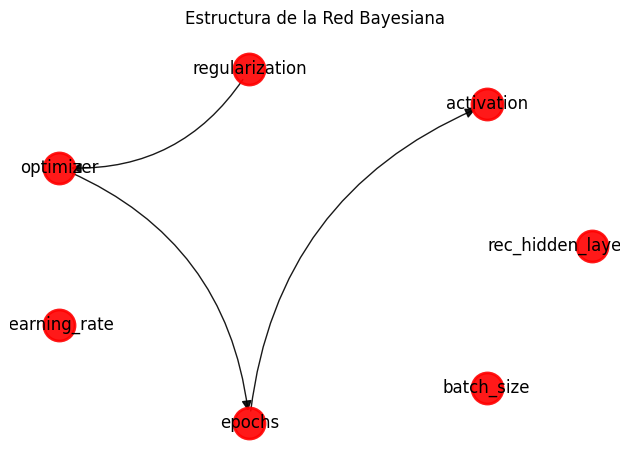

	NFVALS = 120 F = -0.9666666666666667CPU time (s) = 77.82306710900002
	X = ['1024_2048_1024_2048_2048_256_256' 'relu' 'dropout_0.1' 'rmsprop' 0.0005
 200 256]
	Settings: {'size_gen': 20, 'max_iter': 150, 'dead_iter': 2, 'n_variables': 7, 'alpha': 0.8, 'elite_factor': 0.4, 'disp': True, 'parallelize': False}
	History best cost per iteration: [-0.9333333333333333, -0.9333333333333333, -0.9333333333333333, -0.9666666666666667, -0.9333333333333333, -0.9333333333333333]


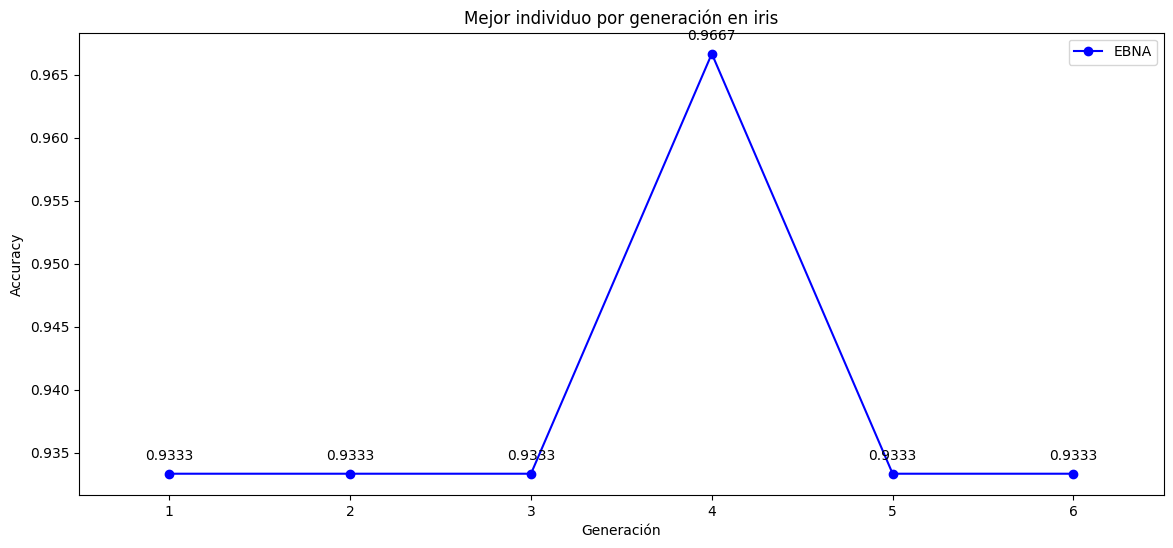

In [ ]:
dataset_name=datasets_multiclase[0]
print(dataset_name)
ebna_result = hyperparameter_search(dataset_name, hyperparameters, size_gen=20, max_iter=150, dead_iter=2,alpha=0.8)
print(ebna_result)
plot_accuracy_evolution(ebna_result, dataset_name)

iris
IT:  0 	Best cost:  -0.9333333333333333
IT:  1 	Best cost:  -0.9666666666666667


IT:  2 	Best cost:  -0.9666666666666667
IT:  3 	Best cost:  -0.9666666666666667
IT:  4 	Best cost:  -0.9666666666666667
IT:  5 	Best cost:  -0.9666666666666667
IT:  6 	Best cost:  -0.9666666666666667
IT:  7 	Best cost:  -0.9666666666666667
IT:  8 	Best cost:  -0.9666666666666667
IT:  9 	Best cost:  -0.9666666666666667
IT:  10 	Best cost:  -0.9666666666666667
	NFEVALS = 260 F = -0.9666666666666667
	X = ['256_256_256_128_2048_1024_2048' 'elu' 'none' 'rmsprop' 0.0001 20 64]


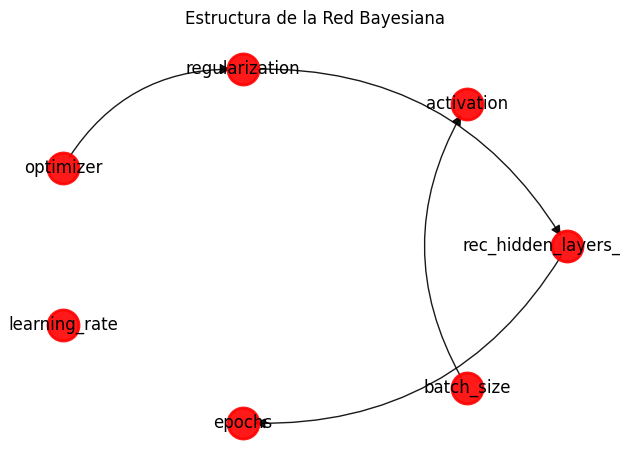

	NFVALS = 260 F = -0.9666666666666667CPU time (s) = 106.98428173599996
	X = ['256_256_256_128_2048_1024_2048' 'elu' 'none' 'rmsprop' 0.0001 20 64]
	Settings: {'size_gen': 20, 'max_iter': 150, 'dead_iter': 10, 'n_variables': 7, 'alpha': 0.8, 'elite_factor': 0.4, 'disp': True, 'parallelize': False}
	History best cost per iteration: [-0.9333333333333333, -0.9333333333333333, -0.9666666666666667, -0.9333333333333333, -0.9333333333333333, -0.9333333333333333, -0.9333333333333333, -0.9333333333333333, -0.9333333333333333, -0.9333333333333333, -0.9666666666666667, -0.9333333333333333, -0.9333333333333333]


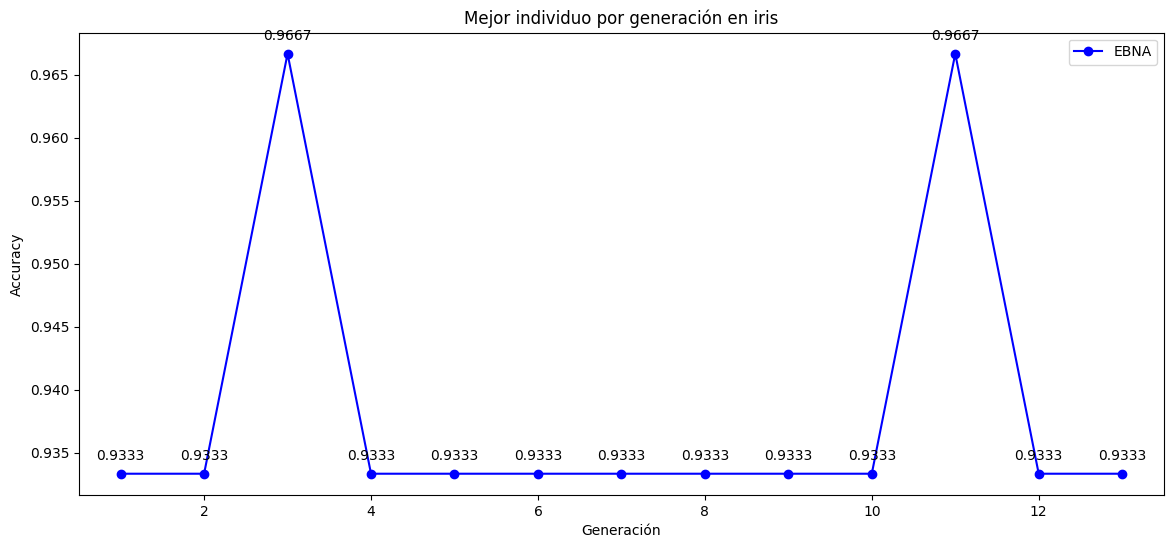

In [ ]:
dataset_name=datasets_multiclase[0]
print(dataset_name)
ebna_result = hyperparameter_search(dataset_name, hyperparameters, size_gen=20, max_iter=150, dead_iter=10,alpha=0.8)
print(ebna_result)
plot_accuracy_evolution(ebna_result, dataset_name)

iris


IT:  0 	Best cost:  -0.9333333333333333


IT:  1 	Best cost:  -0.9666666666666667
IT:  2 	Best cost:  -0.9666666666666667


IT:  3 	Best cost:  -0.9666666666666667
IT:  4 	Best cost:  -0.9666666666666667


IT:  5 	Best cost:  -0.9666666666666667
IT:  6 	Best cost:  -0.9666666666666667


IT:  7 	Best cost:  -0.9666666666666667


IT:  8 	Best cost:  -0.9666666666666667


IT:  9 	Best cost:  -0.9666666666666667
IT:  10 	Best cost:  -0.9666666666666667
	NFEVALS = 455 F = -0.9666666666666667
	X = ['32_512_512_64_2048_128' 'leaky_relu' 'dropout_0.1' 'adam' 0.001 100 256]


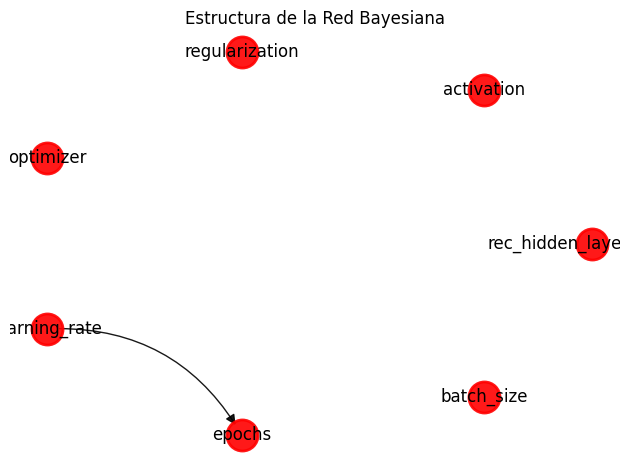

	NFVALS = 455 F = -0.9666666666666667CPU time (s) = 396.936119672
	X = ['32_512_512_64_2048_128' 'leaky_relu' 'dropout_0.1' 'adam' 0.001 100 256]
	Settings: {'size_gen': 35, 'max_iter': 150, 'dead_iter': 10, 'n_variables': 7, 'alpha': 0.8, 'elite_factor': 0.4, 'disp': True, 'parallelize': False}
	History best cost per iteration: [-0.9333333333333333, -0.9333333333333333, -0.9666666666666667, -0.9333333333333333, -0.9666666666666667, -0.9333333333333333, -0.9666666666666667, -0.9333333333333333, -0.9333333333333333, -0.9333333333333333, -0.9333333333333333, -0.9333333333333333, -0.9666666666666667]


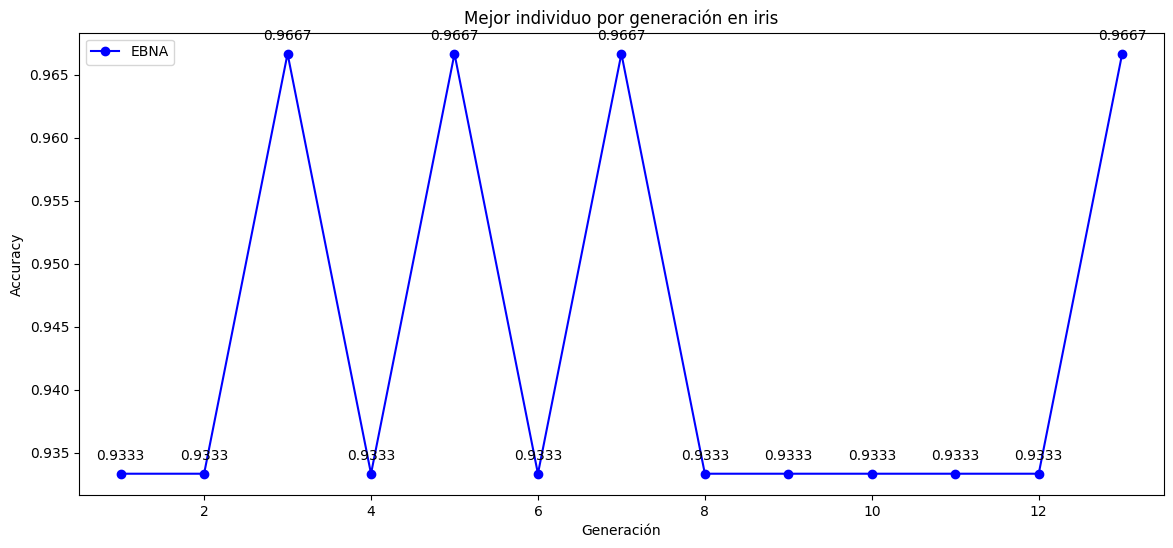

In [ ]:
dataset_name=datasets_multiclase[0]
print(dataset_name)
ebna_result = hyperparameter_search(dataset_name, hyperparameters, size_gen=35, max_iter=150, dead_iter=10,alpha=0.8)
print(ebna_result)
plot_accuracy_evolution(ebna_result, dataset_name)

digits


IT:  0 	Best cost:  -0.9861111111111112
IT:  1 	Best cost:  -0.9888888888888889


IT:  2 	Best cost:  -0.9916666666666667
IT:  3 	Best cost:  -0.9972222222222222
IT:  4 	Best cost:  -0.9972222222222222
IT:  5 	Best cost:  -0.9972222222222222
IT:  6 	Best cost:  -0.9972222222222222
IT:  7 	Best cost:  -0.9972222222222222
IT:  8 	Best cost:  -0.9972222222222222
IT:  9 	Best cost:  -0.9972222222222222
IT:  10 	Best cost:  -0.9972222222222222
IT:  11 	Best cost:  -0.9972222222222222
IT:  12 	Best cost:  -0.9972222222222222
	NFEVALS = 375 F = -0.9972222222222222
	X = ['512_256_512_1024_1024_64_32' 'leaky_relu' 'dropout_0.1' 'adamw' 0.0001
 200 64]


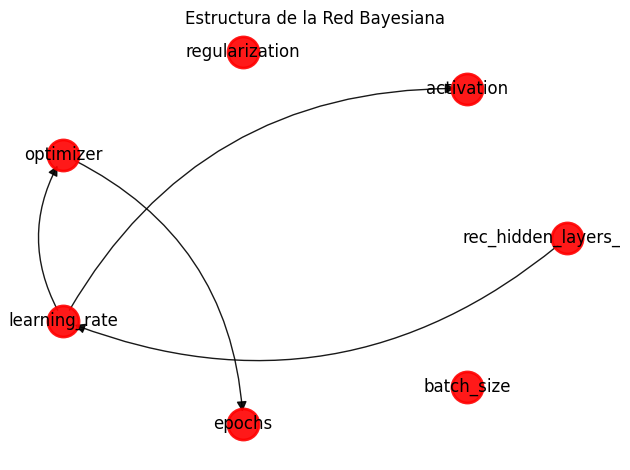

	NFVALS = 375 F = -0.9972222222222222CPU time (s) = 2709.8201778869998
	X = ['512_256_512_1024_1024_64_32' 'leaky_relu' 'dropout_0.1' 'adamw' 0.0001
 200 64]
	Settings: {'size_gen': 25, 'max_iter': 150, 'dead_iter': 10, 'n_variables': 7, 'alpha': 0.5, 'elite_factor': 0.4, 'disp': True, 'parallelize': False}
	History best cost per iteration: [-0.9888888888888889, -0.9861111111111112, -0.9888888888888889, -0.9916666666666667, -0.9972222222222222, -0.9972222222222222, -0.9944444444444445, -0.9944444444444445, -0.9944444444444445, -0.9972222222222222, -0.9944444444444445, -0.9944444444444445, -0.9944444444444445, -0.9972222222222222, -0.9944444444444445]


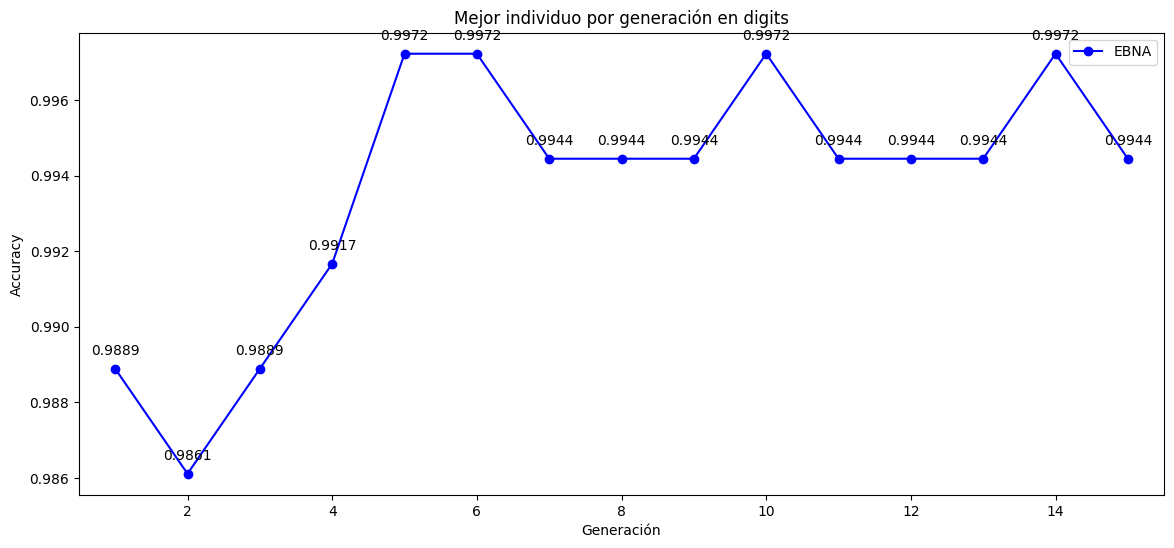

In [ ]:
dataset_name=datasets_multiclase[1]
print(dataset_name)
ebna_result = hyperparameter_search(dataset_name, hyperparameters, size_gen=25, max_iter=150, dead_iter=10,alpha=0.5)
print(ebna_result)
plot_accuracy_evolution(ebna_result, dataset_name)

digits


IT:  0 	Best cost:  -0.9888888888888889
IT:  1 	Best cost:  -0.9944444444444445
IT:  2 	Best cost:  -0.9944444444444445


IT:  3 	Best cost:  -0.9944444444444445


IT:  4 	Best cost:  -0.9944444444444445


IT:  5 	Best cost:  -0.9972222222222222
IT:  6 	Best cost:  -0.9972222222222222
IT:  7 	Best cost:  -0.9972222222222222
IT:  8 	Best cost:  -0.9972222222222222
IT:  9 	Best cost:  -0.9972222222222222


IT:  10 	Best cost:  -0.9972222222222222


IT:  11 	Best cost:  -0.9972222222222222
IT:  12 	Best cost:  -0.9972222222222222
IT:  13 	Best cost:  -0.9972222222222222


IT:  14 	Best cost:  -0.9972222222222222
	NFEVALS = 850 F = -0.9972222222222222
	X = ['2048_2048_64_128_128_32_256' 'elu' 'dropout_0.2' 'rmsprop' 0.0001 200 64]


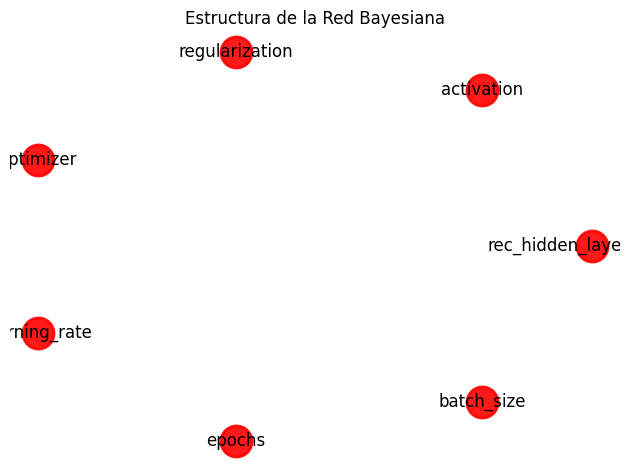

	NFVALS = 850 F = -0.9972222222222222CPU time (s) = 12408.381739059
	X = ['2048_2048_64_128_128_32_256' 'elu' 'dropout_0.2' 'rmsprop' 0.0001 200 64]
	Settings: {'size_gen': 50, 'max_iter': 150, 'dead_iter': 10, 'n_variables': 7, 'alpha': 0.8, 'elite_factor': 0.4, 'disp': True, 'parallelize': False}
	History best cost per iteration: [-0.9888888888888889, -0.9888888888888889, -0.9944444444444445, -0.9944444444444445, -0.9944444444444445, -0.9944444444444445, -0.9972222222222222, -0.9972222222222222, -0.9972222222222222, -0.9972222222222222, -0.9944444444444445, -0.9972222222222222, -0.9972222222222222, -0.9972222222222222, -0.9972222222222222, -0.9972222222222222, -0.9972222222222222]


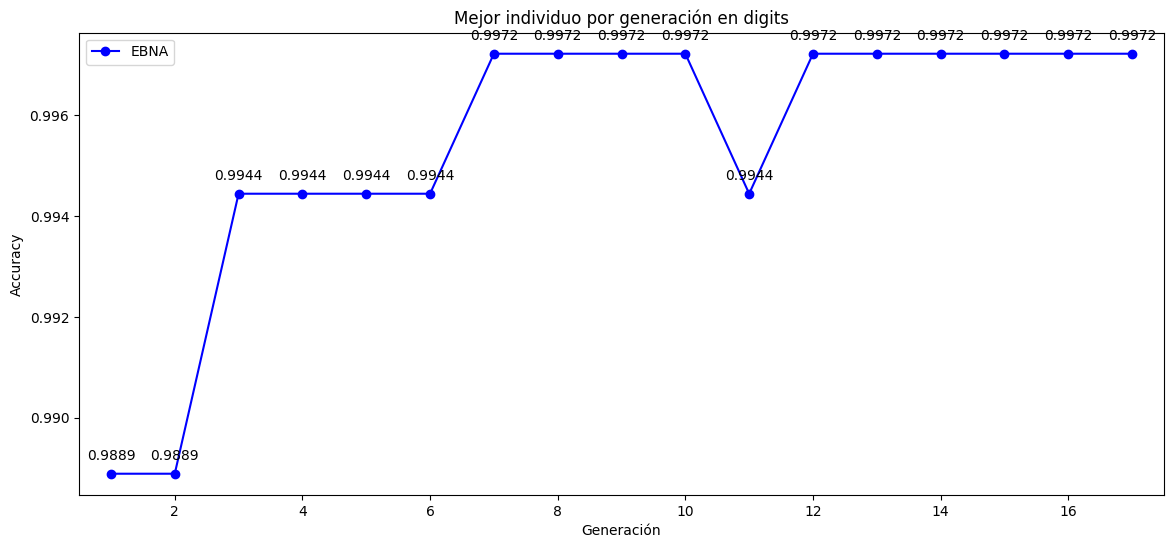

In [ ]:
dataset_name=datasets_multiclase[1]
print(dataset_name)
ebna_result = hyperparameter_search(dataset_name, hyperparameters, size_gen=50, max_iter=150, dead_iter=10,alpha=0.8)
print(ebna_result)
plot_accuracy_evolution(ebna_result, dataset_name)

wine


IT:  0 	Best cost:  -0.8333333333333334


IT:  1 	Best cost:  -0.8888888888888888
IT:  2 	Best cost:  -0.9444444444444444
IT:  3 	Best cost:  -1.0
IT:  4 	Best cost:  -1.0
IT:  5 	Best cost:  -1.0
IT:  6 	Best cost:  -1.0
IT:  7 	Best cost:  -1.0


IT:  8 	Best cost:  -1.0
IT:  9 	Best cost:  -1.0


IT:  10 	Best cost:  -1.0


IT:  11 	Best cost:  -1.0


IT:  12 	Best cost:  -1.0
	NFEVALS = 750 F = -1.0
	X = ['1024_512_128_1024_64_32' 'tanh' 'none' 'adamw' 5e-05 200 256]


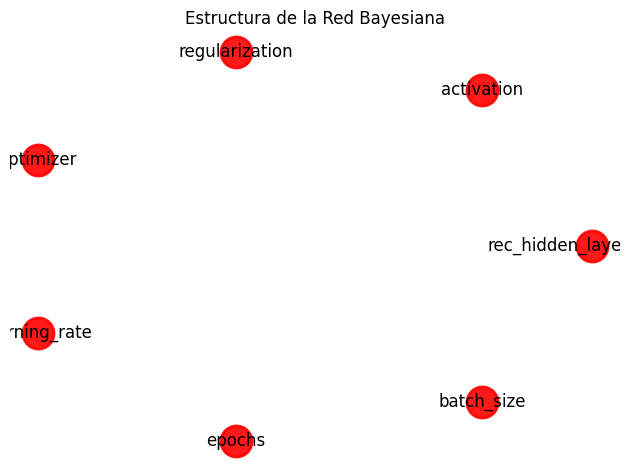

	NFVALS = 750 F = -1.0CPU time (s) = 726.4087681450001
	X = ['1024_512_128_1024_64_32' 'tanh' 'none' 'adamw' 5e-05 200 256]
	Settings: {'size_gen': 50, 'max_iter': 150, 'dead_iter': 10, 'n_variables': 7, 'alpha': 0.8, 'elite_factor': 0.4, 'disp': True, 'parallelize': False}
	History best cost per iteration: [-0.9444444444444444, -0.8333333333333334, -0.8888888888888888, -0.9444444444444444, -1.0, -0.9722222222222222, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9722222222222222, -1.0]


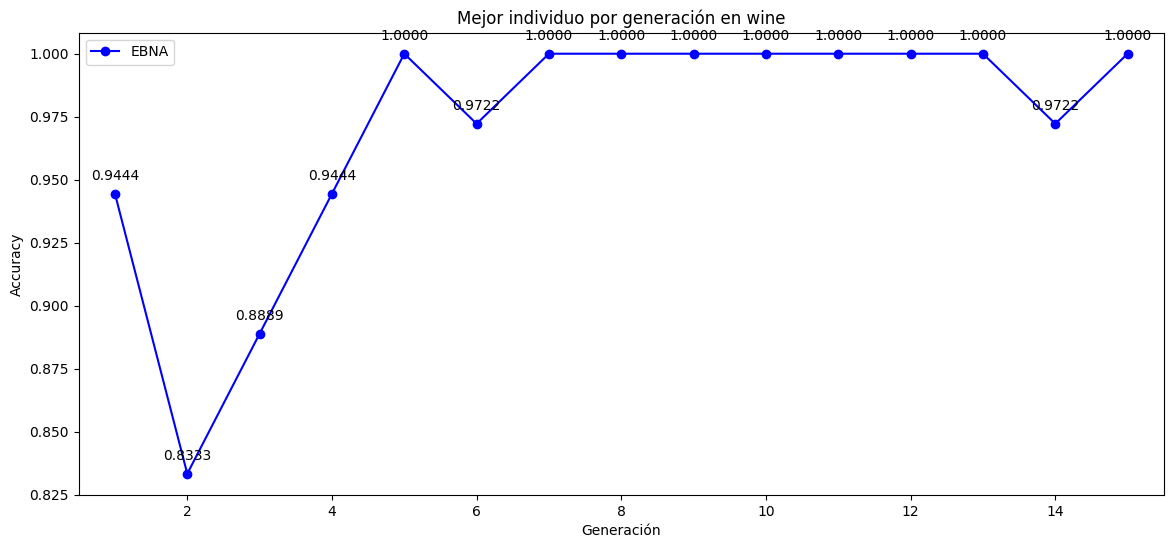

In [ ]:
dataset_name=datasets_multiclase[2]
print(dataset_name)
ebna_result = hyperparameter_search(dataset_name, hyperparameters, size_gen=50, max_iter=150, dead_iter=10,alpha=0.8)
print(ebna_result)
plot_accuracy_evolution(ebna_result, dataset_name)

In [ ]:
dataset_name=datasets_multiclase[3]
print(dataset_name)
ebna_result = hyperparameter_search(dataset_name, hyperparameters, size_gen=10, max_iter=150, dead_iter=10,alpha=0.8)
print(ebna_result)
plot_accuracy_evolution(ebna_result, dataset_name)

forest_covertypes
Las etiquetas han sido ajustadas para empezar en 0.
tensor([0, 1, 2, 3, 4, 5, 6])


In [ ]:
dataset_name=datasets_multiclase[3]
print(dataset_name)
ebna_result = hyperparameter_search(dataset_name, hyperparameters, size_gen=50, max_iter=150, dead_iter=10,alpha=0.8)
print(ebna_result)
plot_accuracy_evolution(ebna_result, dataset_name)